In [240]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os
from sklearn.cluster import KMeans

In [241]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    """
    Rotates a 2D tuple (point) by a given angle in degrees.

    Args:
        point: A tuple (x, y).
        angle_degrees: Angle to rotate the point, in degrees.

    Returns:
        A tuple (x', y') representing the rotated point.
    """
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def multiply_tuple(point, scale):
    return tuple(element * scale for element in point)

def add_tuple(x, y):
    return (x[0] + y[0], x[1] + y[1])

In [242]:
def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude_squared(v):
        return v[0]**2 + v[1]**2
    
    # Unpack rectangle vertices
    A, B, C, D = rect
    
    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)
    
    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)
    
    return within_AB and within_AD

In [243]:
def uniform_grid_sampling_with_descriptors(image, keypoints, descriptors, rows=4, cols=4, top_k=5):
    """
    Performs uniform grid sampling on keypoints and descriptors.

    Args:
        image: The input image (used for determining dimensions).
        keypoints: List of keypoints detected in the image.
        descriptors: Corresponding descriptors for the keypoints.
        rows: Number of rows to divide the image into.
        cols: Number of columns to divide the image into.
        top_k: Maximum number of keypoints/descriptors to keep per grid cell.

    Returns:
        filtered_keypoints: List of filtered keypoints.
        filtered_descriptors: Numpy array of filtered descriptors.
    """
    height, width = image.shape[:2]
    cell_height = height // rows
    cell_width = width // cols

    filtered_keypoints = []
    filtered_descriptors = []

    for i in range(rows):
        for j in range(cols):
            # Define the boundaries of the current grid cell
            x_start, y_start = j * cell_width, i * cell_height
            x_end, y_end = x_start + cell_width, y_start + cell_height

            # Select keypoints within this cell
            cell_keypoints = [(kp, idx) for idx, kp in enumerate(keypoints)
                              if x_start <= kp.pt[0] < x_end and y_start <= kp.pt[1] < y_end]

            # Sort keypoints in the cell by response value
            cell_keypoints = sorted(cell_keypoints, key=lambda kp_idx: kp_idx[0].response, reverse=True)[:top_k]

            # Keep the top_k keypoints and their corresponding descriptors
            for kp, idx in cell_keypoints:
                filtered_keypoints.append(kp)
                filtered_descriptors.append(descriptors[idx])

    # Convert the filtered descriptors to a numpy array
    filtered_descriptors = np.array(filtered_descriptors)

    return filtered_keypoints, filtered_descriptors


Looking for 0.jpg...
False positive (poorly distributed keypoints): 12
Looking for 1.jpg...
False positive (poorly distributed keypoints): 4
Looking for 11.jpg...
False positive (poorly distributed keypoints): 3
Looking for 19.jpg...
False positive (poorly distributed keypoints): 2
Looking for 24.jpg...
Valid match (well-distributed keypoints): 19
Looking for 25.jpg...
False positive (poorly distributed keypoints): 16
Looking for 26.jpg...
Valid match (well-distributed keypoints): 20


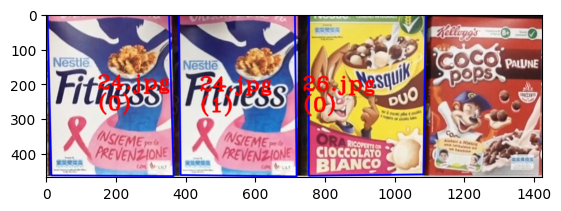

In [252]:
def find_image(scene_path, model_paths, draw_on_color=True):
    target_resolution = (150,210) #(250, 350) # aspect ratio: 4.2/3 or 1.4/1
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        print(f"Looking for {model["name"]}...")

        #model_gray = model["img"]
        """base_model_gray = model["img"]
        blurred_model = cv.bilateralFilter(base_model_gray, 9, 75, 75)  # Edge-preserving smoothing
        model_gray = cv.resize(blurred_model, target_resolution, interpolation=cv.INTER_AREA)"""

        # Apply model preprocessing
        model_gray = model["img"]
        model_gray = cv.resize(model_gray, target_resolution, interpolation=cv.INTER_AREA)
        #model_gray = cv.bilateralFilter(model_gray, 9, 75, 75)  # Edge-preserving smoothing
        #model_gray = cv.adaptiveThreshold(model_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY, 11, 2)
        MIN_MATCH_COUNT = 80 #100

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        """model_draw = model["img"]
        for kp in kp_model:
            cv.circle(model_draw, [int(kp.pt[0]), int(kp.pt[1])], 3, (0,0,255), 2)
        plt.imshow(cv.cvtColor(model_draw, cv.COLOR_BGR2RGB))
        plt.show()"""

        #print("Found {} keypoints in model".format(len(kp_model)))
        #print("Found {} keypoints in scene".format(len(kp_scene)))

        # only retain representative keypoints, effectively reducing dense feature regions.
        # kmeans, not good loses exact features for estimated centers.
        """keypoints_coords = np.array([kp.pt for kp in kp_model])
        kmeans = KMeans(n_clusters=200).fit(keypoints_coords)  # Limit to 500 clusters
        kp_model = [kp_model[i] for i in kmeans.labels_]"""

        """kp_model, des1 = uniform_grid_sampling_with_descriptors(model_gray, kp_model, des1, rows=20, cols=20, top_k=2)"""

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        result = scene_to_draw_on

        src_kp = [kp_model[m.queryIdx] for m in good]
        dst_kp = [kp_scene[m.trainIdx] for m in good]

        """tmp = model_gray.copy()
        for kp in src_kp:
            cv.circle(tmp, [int(kp.pt[0]), int(kp.pt[1])], 3, (0,0,255), 2)
        plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB))
        plt.show()"""

    #--------------------------------------------------------------------------------------
    # Selection via Homography
        """MIN_INLIERS = 10

        if len(good) >= MIN_MATCH_COUNT:
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
            matches_mask = mask.ravel().tolist()

            if M is not None and sum(matches_mask) > MIN_INLIERS:
                # Accept only if enough inliers are found
                print("Object correctly validated using homography:", sum(matches_mask))
            else:
                print("False positive detected or homography failed:", sum(matches_mask))
        """

    #--------------------------------------------------------------------------------------
    # Selection via Weighted sum of Distance
        """DISTANCE_THRESHOLD = 30
        # Weigh matches based on distances
        weighted_matches = [m.distance for m in good]
        weight_sum = sum(weighted_matches)
        print("Weighted distances:", weight_sum)

        if weight_sum < DISTANCE_THRESHOLD:
            print("Image validated based on weighted distances")
        else:
            print("False positive detected based on weights")"""

    #--------------------------------------------------------------------------------------
    # Selection via Grid Feature Threshold
        THRESHOLD_GRIDS = 18

        # Define the dimensions of the target image
        h, w = model_gray.shape
        grid_size_x = 4  # Divide image into a grid (e.g., 5x5)
        grid_size_y = 5
        grid_matches = [[0] * grid_size_x for _ in range(grid_size_y)]

        for match in good:
            x, y = kp_model[match.queryIdx].pt  # Get match coordinates
            grid_x = int(x / (w / grid_size_x))
            grid_y = int(y / (h / grid_size_y))
            grid_matches[grid_y][grid_x] += 1

        # Count non-empty grid cells
        matched_grids = sum(1 for row in grid_matches for cell in row if cell > 0)

        if matched_grids >= THRESHOLD_GRIDS:
            print("Valid match (well-distributed keypoints):", matched_grids)
        else:
            print("False positive (poorly distributed keypoints):", matched_grids)
            continue


        if len(good)>=MIN_MATCH_COUNT:
            #print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            
            """rc_kp = [kp_model[m.queryIdx] for m in good]
            dst_kp = [kp_scene[m.trainIdx] for m in good]"""

            """tmp = model_gray.copy()
            for kp in src_kp:
                cv.circle(tmp, [int(kp.pt[0]), int(kp.pt[1])], 3, (0,0,255), 2)
            plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB))
            plt.show()"""

            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            #draw barycenter
            tmp = model_gray.copy()
            #cv.circle(tmp, barycenter, 3, (0,0,255), 2)
            #plt.imshow(tmp)
            #plt.show()

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            tmp = scene_to_draw_on.copy()

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                #delta_phi = d.angle/s.angle
                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)

                #cv.line(tmp, bary_predict, [int(pt_x), int(pt_y)], (0,0,255), 1)

            #plt.imshow(tmp)
            #plt.show()


            GRID_RESOLUTION = 25
            MIN_VOTES = 25
            x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
            y_cell = x_cell

            y_cells_n = int(scene_gray.shape[1]//y_cell + 1)
            #grid = np.zeros((GRID_RESOLUTION, GRID_RESOLUTION))

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            #print("Scene:", scene_gray.shape)
            #print("Grid:", grid)

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            # assign features matches and barycenters to grids
            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    #print((x_idx, y_idx))
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)
                else:
                    pass
                    #print("barycenter votes out of range")

            # select vote winners in grid
            barygrid_means = []
            winners = []
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        #print(f"Enough Votes for ({i},{j}):{len(grid[i][j])}")
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))
                    else:
                        if len(grid[i][j])>10:
                            #print(f"Not enough Votes for ({i},{j}):{len(grid[i][j])}")
                            pass

            
            #draw grid
            """image = scene_to_draw_on.copy()
            height, width, _ = image.shape

            num_vertical_lines = width // x_cell
            num_horizontal_lines = height // y_cell

            for i in range(1, num_vertical_lines):
                x = i * x_cell
                cv.line(image, (x, 0), (x, height), color=(0, 0, 255), thickness=1)

            for i in range(1, num_horizontal_lines):
                y = i * y_cell
                cv.line(image, (0, y), (width, y), color=(0, 0, 255), thickness=1)

            for o in barycenter_votes:
                cv.circle(image, o, 3, (0,0,255), 2)
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.show()"""
            ############

            

            i = 0

            ignored_area = []

            for winner, barygrid_mean in zip(winners, barygrid_means):

                foo = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        foo = True
                        break
                if foo:
                    continue


                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                matchesMask = mask.ravel().tolist()
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,
                                                h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)

                #add square and add text
                means = np.mean(dst, axis=0)
                x, y = [a for a in means[0]]
                x = x * 0.8 #adjust for text

                result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

                boldness = 3
                size = 3
                cv.putText(scene_to_draw_on, f"{model["name"]}", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                cv.putText(scene_to_draw_on, f"({i})", (int(x),int(y)+60), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                i = i + 1

                ignored_area.append([o[0] for o in np.int32(dst)])

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

    #print("------------------------------------------")
    #print("Results:")
    return result


#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m1.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Valid match (well-distributed keypoints): 20
Looking for 1.jpg...
Valid match (well-distributed keypoints): 18
Not enough matches are found - 77/80
Looking for 11.jpg...
Valid match (well-distributed keypoints): 18
Not enough matches are found - 77/80
Looking for 19.jpg...
False positive (poorly distributed keypoints): 1
Looking for 24.jpg...
False positive (poorly distributed keypoints): 1
Looking for 25.jpg...
False positive (poorly distributed keypoints): 3
Looking for 26.jpg...
False positive (poorly distributed keypoints): 12


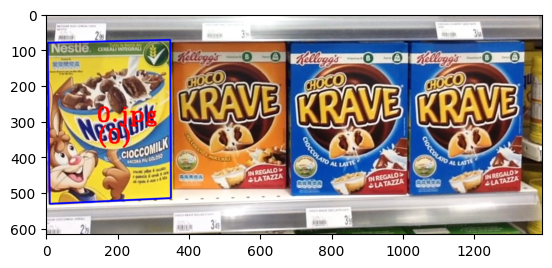

In [245]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m2.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
False positive (poorly distributed keypoints): 13
Looking for 1.jpg...
False positive (poorly distributed keypoints): 6
Looking for 11.jpg...
False positive (poorly distributed keypoints): 3
Looking for 19.jpg...
Valid match (well-distributed keypoints): 20
Looking for 24.jpg...
False positive (poorly distributed keypoints): 1
Looking for 25.jpg...
False positive (poorly distributed keypoints): 14
Looking for 26.jpg...
Valid match (well-distributed keypoints): 18


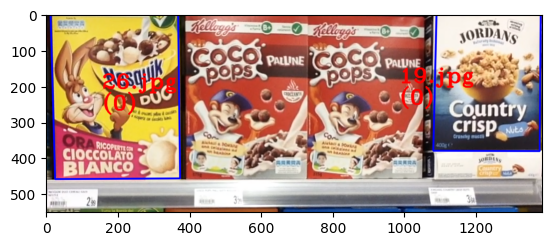

In [246]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m3.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
False positive (poorly distributed keypoints): 12
Looking for 1.jpg...
False positive (poorly distributed keypoints): 5
Looking for 11.jpg...
False positive (poorly distributed keypoints): 4
Looking for 19.jpg...
False positive (poorly distributed keypoints): 1
Looking for 24.jpg...
False positive (poorly distributed keypoints): 15
Looking for 25.jpg...
False positive (poorly distributed keypoints): 15
Looking for 26.jpg...
Valid match (well-distributed keypoints): 19


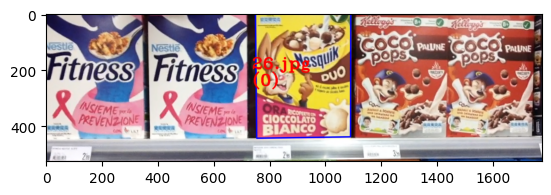

In [251]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m4.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
False positive (poorly distributed keypoints): 1
Looking for 1.jpg...
Valid match (well-distributed keypoints): 19
Not enough matches are found - 71/80
Looking for 11.jpg...
False positive (poorly distributed keypoints): 16
Looking for 19.jpg...
Valid match (well-distributed keypoints): 20
Looking for 24.jpg...
False positive (poorly distributed keypoints): 3
Looking for 25.jpg...
False positive (poorly distributed keypoints): 14
Looking for 26.jpg...
False positive (poorly distributed keypoints): 4


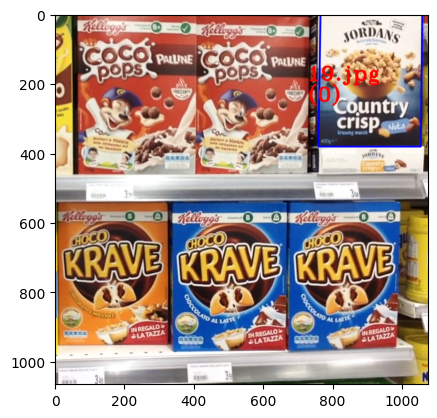

In [248]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m5.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()